# Sensitivity of sequana_coverage in detecting CNVs

    Author: Thomas Cokelaer
    Jan 2018
    Local time execution: about 10  minutes

In this notebook, we will simulated fastq reads and inject CNVs. We will then look at the sensitivity (measures the proportion of positives that are correctly identified as such) of sequana_coverage.

We use the data and strategy described in section 3.2 of "CNOGpro: detection and quantification 
of  CNVs in prokaryotic whole-genome sequencing data, bioinformatics 31(11), 2015 (Brynildsrud et al)"

Here, we will use the same reference: FN433596 (staphylococcus aureus) as in the paper above, which is also used in the manuscript 

The main goal is to generate simulated data, and check that the sensitivity is high (keeping specificity low) by injecting various CNVs.

# Requirements

- sequana version 0.6.4 was used
- art_illumina
- bioconvert 0.0.12 (optional) or bedtools

# Get the reference 

There are many ways to download the reference (FN433596). Here below we use sequana_coverage tool but of course, you can use your own tool, or simply go to http://github.com/sequana/resources/coverage (look for FN433596.fasta.bz2).

In [1]:
!sequana_coverage --download-reference FN433596

INFO    [sequana]:  Downloading reference FN433596 from ENA



# Simulated FastQ data 

Simulation of data coverage 100X

```
-l: length of the reads
-f: coverage
-m: mean size of fragments
-s: standard deviation of fragment size
-ss: type of hiseq
```
This taks a few minutes to produce 

In [2]:
! art_illumina -sam -i FN433596.fa -p -l 100 -ss HS20 -f 20 -m 500 -s 40 -o paired_dat -f 100

=======================================ART======================================
                            ART_Illumina (2008-2015)                            
                            Q Version 2.3.7 (Mar 19, 2015)                      
                     Contact: Weichun Huang at whduke@gmail.com                 

                          Paired-end sequencing simulation

Total CPU time used: 53.29

The random seed for the run: 1517577832

Parameters used during run
	Read Length:	100
	Genome masking 'N' cutoff frequency: 	1 in 100
	Fold Coverage:            100X
	Mean Fragment Length:     500
	Standard Deviation:       40
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   HiSeq 2000 Length 100 R1 (built-in profile) 
	First Read:   HiSeq 2000 Length 100 R2 (built-in profile) 
Output files

  FASTQ Sequence Files:
	 the 1st reads: paired_dat1.fq
	 the 2nd reads: paired_dat2.fq

  ALN Alignment Files:
	 the 1st reads: paired_dat1.a

# Creating the BAM (mapping) and BED files

In [3]:
# no need for the *aln and *sam, let us remove them to save space
!rm -f paired*.aln paired_dat.sam
!sequana_mapping --reference FN433596.fa --file1 paired_dat1.fq --file2 paired_dat2.fq  1>out 2>err


This uses bwa and samtools behind the scene. Then, we will convert the resulting BAM file (FN433596.fasta.sorted.bam) into a BED file once for all. To do so, we use bioconvert (http://bioconvert.readthedocs.io) that uses bedtools behind the scene:

In [4]:
!bioconvert FN433596.fa.sorted.bam simulated.bed -f
# or use e.g. bedtools:
# bedtools genomecov -d -ibam input.bam > output.bed

INFO    [bioconvert.core.converter]:  Input: BAM
INFO    [bioconvert.core.converter]:  Output: BED
INFO    [bioconvert.core.converter]:  Using BAM2BED class
INFO    [bioconvert]:  Converting from BAM to BED
INFO    [bioconvert.core.base]:  Executing samtools method
INFO    [bioconvert.core.base]:  BAM2BED> 
INFO    [bioconvert.core.base]:  CMD: samtools depth -aa FN433596.fa.sorted.bam > simulated.bed
INFO    [bioconvert.core.shell]:  samtools depth -aa FN433596.fa.sorted.bam > simulated.bed
INFO    [bioconvert.core.base]:  Took 17.349427700042725 seconds 


# sequana_coverage

We execute sequana_coverage to find the ROI (region of interest). We should a few detections (depends on the threshold and length of the genome of course). 

Later, we will inject events as long as 8000 bases. So, we should use at least 16000 bases for the window parameter length. As shown in the window_impact notebook a 20,000 bases is a good choice to keep false detection rate low. 

In [5]:
!sequana_coverage --input simulated.bed --reference FN433596.fa -w 20001 -o --level WARNING
!cp report/*/*/rois.csv rois_noise_20001.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.
Computing 2D histogram. Please wait
[WARNING]         multiqc : MultiQC Version v1.4 now available!
[INFO   ]         multiqc : This is MultiQC v1.0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Report title: Sequana multi summary
[INFO   ]         multiqc : Searching '.'
[INFO   ]         multiqc : Only using modules sequana_coverage
Searching 35 files..  [####################################]  100%
[INFO   ]        coverage : Found 1 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : multiqc_report.html
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete


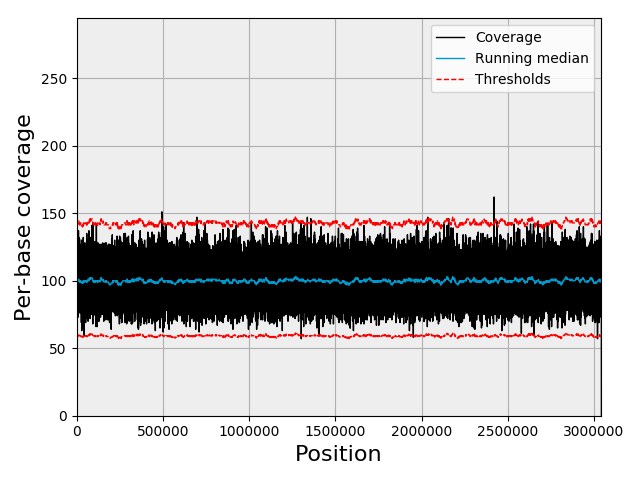

In [6]:
# An instance of coverage signal (yours may be slightly different)
from IPython.display import Image
Image("coverage.png")

# The false positives

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
# Here is a convenient function to plot the ROIs in terms of sizes
# and max zscore

def plot_results(file_roi):
    import pandas as pd
    roi = pd.read_csv(file_roi) #"rois_cnv_deletion.csv")
    roi = roi.query("start>100 and end<3043210")
    plot(roi["size"], roi["max_zscore"], "or", label="candidate ROIs")
    for this in [3,4,-3,-4]:
        if this == 3: label = "thresholds"
        else: label="_nolegend_"
        axhline(this, ls="--", label=label)
    print("{} ROIs found".format(len(roi)))
    xlabel("length of the ROIs")
    ylabel("z-scores")
    legend()
    return roi

49 ROIs found


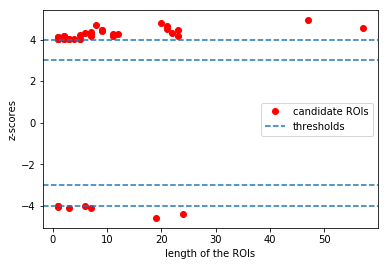

In [9]:
roi = plot_results("rois_noise_20001.csv")

Most of the detected events have a zscore close to the chosen thresholds (-4 and 4). Moreover, 
most events and a size below 30

# Checking CNV detection

## Event injections (deletion, duplication, or mix of both)

In [11]:
import random
import pandas as pd

def create_deletion():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    positions = []
    sizes = []
    for i in range(80):
        # the + and -4000 shift are there to guarantee the next
        # CNV does not overlap with the previous one since
        # CNV length can be as much as 8000
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)    
        #size = 2000
        df.loc[pos:pos+size,2] = 0 #deletion
        sizes.append(size)
    df.to_csv("cnv_deletion.bed", sep="\t", header=None, index=None)
    return positions, sizes


def create_duplicated():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    positions = []
    sizes = []
    for i in range(80):
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)    
        
        df.loc[pos:pos+size,2] += 100 #duplicated
        sizes.append(size)
    df.to_csv("cnv_duplicated.bed", sep="\t", header=None, index=None)
    return positions, sizes


def create_cnvs_mixed():
    df = pd.read_csv("simulated.bed", sep="\t", header=None)
    # we will place 10% of CNV of size from 1000 to 8000
    import random
    positions = []
    sizes = []
    for i in range(80):
        pos = random.randint(37000*i+4000, 37000*(i+1)-4000)
        size = random.randint(1,8) * 1000
        positions.append(pos)
    
        status = random.randint(0,1)
    
        if status == 0:
            df.loc[pos:pos+size,2] -= 50 
        elif status == 1:
            df.loc[pos:pos+size,2] += 50 
        
        sizes.append(size)
    df.to_csv("cnv_mixed.bed", sep="\t", header=None, index=None)
    return positions, sizes



In [29]:
def check_found(positions, sizes, roi, precision=200, min_size=150):
    """A simple function to check given the position and size that
    the injected CNVs are detected in the ROIs
    
    We check that the starting or ending position of at least one
    ROI coincide with one ROI and that this ROI has at least a length of 200.
    
    Indeed, injections are at least 1000 bases and noise are generally below 100 bases
    as shown above.
    
    
    """
    found = [False] * len(positions)
    i = 0
    for position,size in zip(positions, sizes):

        for this in roi.iterrows():
            this = this[1]        
            if (abs(this.start-position)<precision or abs(this.end-position-size)<precision )and this['size'] > min_size:
                #print(this.start, this.end, position, size)
                found[i] = True
                continue
        
        if found[i] is False:
            print("position not found {} size={}".format(position, size))
        i+=1
    print("Found {}".format(sum(found)))
    return 


# Deleted regions are all detected

In [13]:
# call this only once !!!!
positions_deletion, sizes_deletion = create_deletion()
!sequana_coverage --input cnv_deletion.bed -o -w 20001 --level WARNING 
!cp report/*/*/rois.csv rois_cnv_deleted.csv

WARNING [sequana]:  There is only one chromosome. Selected automatically.
[WARNING]         multiqc : MultiQC Version v1.4 now available!
[INFO   ]         multiqc : This is MultiQC v1.0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Report title: Sequana multi summary
[INFO   ]         multiqc : Searching '.'
[INFO   ]         multiqc : Only using modules sequana_coverage
Searching 39 files..  [####################################]  100%
[INFO   ]        coverage : Found 1 reports
[INFO   ]         multiqc : Compressing plot data
[WARNING]         multiqc : Deleting    : multiqc_report.html   (-f was specified)
[INFO   ]         multiqc : Report      : multiqc_report.html
[WARNING]         multiqc : Deleting    : multiqc_data   (-f was specified)
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete


94 ROIs found


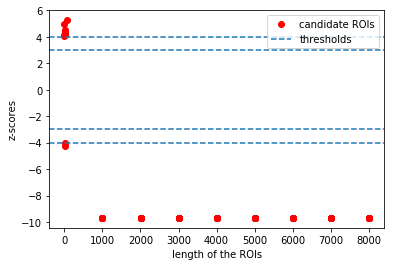

In [14]:
rois_deletion = plot_results("rois_cnv_deleted.csv")

In [15]:
# as precise as 2 base positions. Here we put 20 we 2 should give pretty 
# high detection rate already. 
check_found(positions_deletion, sizes_deletion, rois_deletion, 
            precision=20)

Found 80


# duplicated regions

In [17]:
positions_duplicated, sizes_duplicated = create_duplicated()
!sequana_coverage --input cnv_duplicated.bed -o -w 20001 --level ERROR 
!cp report/*/*/rois.csv rois_cnv_duplicated.csv

[WARNING]         multiqc : MultiQC Version v1.4 now available!
[INFO   ]         multiqc : This is MultiQC v1.0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Report title: Sequana multi summary
[INFO   ]         multiqc : Searching '.'
[INFO   ]         multiqc : Only using modules sequana_coverage
Searching 39 files..  [####################################]  100%
[INFO   ]        coverage : Found 1 reports
[INFO   ]         multiqc : Compressing plot data
[WARNING]         multiqc : Deleting    : multiqc_report.html   (-f was specified)
[INFO   ]         multiqc : Report      : multiqc_report.html
[WARNING]         multiqc : Deleting    : multiqc_data   (-f was specified)
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete


100 ROIs found


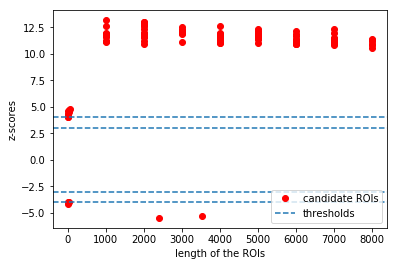

In [18]:
rois_duplicated = plot_results("rois_cnv_duplicated.csv")

Note that you may see events with negative zscore. Those are false detection due to the presence of two CNVs close to each other. This can be avoided by increasing the window size e.g. to 30000


In [19]:
check_found(positions_duplicated, sizes_duplicated, rois_duplicated, 
            precision=20)

Found 80


# Mixes of duplicated and deleted regions

In [21]:
positions_mix, sizes_mix = create_cnvs_mixed()
!sequana_coverage --input cnv_mixed.bed -o -w 20001 --level ERROR 
!cp report/*/*/rois.csv rois_cnv_mixed.csv

[WARNING]         multiqc : MultiQC Version v1.4 now available!
[INFO   ]         multiqc : This is MultiQC v1.0
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Report title: Sequana multi summary
[INFO   ]         multiqc : Searching '.'
[INFO   ]         multiqc : Only using modules sequana_coverage
Searching 39 files..  [####################################]  100%
[INFO   ]        coverage : Found 1 reports
[INFO   ]         multiqc : Compressing plot data
[WARNING]         multiqc : Deleting    : multiqc_report.html   (-f was specified)
[INFO   ]         multiqc : Report      : multiqc_report.html
[WARNING]         multiqc : Deleting    : multiqc_data   (-f was specified)
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete


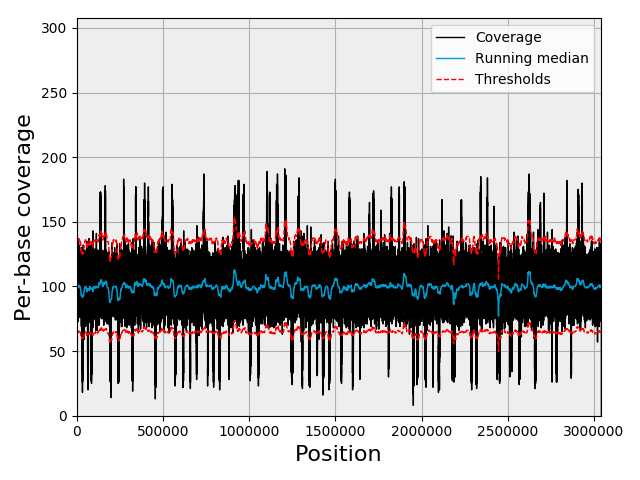

In [22]:
Image("coverage_with_cnvs.png")

372 ROIs found


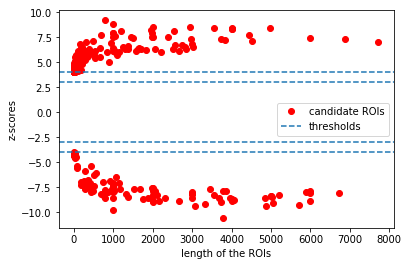

In [23]:
rois_mixed = plot_results("rois_cnv_mixed.csv")

In [33]:
# note that here we increase the precision to 100 bases. The positions
# are not as precise as in the duplciation or deletion cases. 
check_found(positions_mix, sizes_mix, rois_mixed,precision=100)

Found 80


# Conclusions

- pure simulated: the events that passes the threshold are limited to a few tens of detection with zscore close to the threshold of 4 and with sizes below 100 bases. 
- Simulated CNVs:
    - the 80 deletions are all detected with the correct position and sizes
    - the 80 duplications are all detected with the correct position and sizes
    - the mix of 80 detection with coverage at 50 and 150 are all detected. Note, however, that some CNVs detections are split in several events. For instance instead of a 3000 length region, two regions of about 1000 and 2000 may be detected separately.
    
You may get 78 or 79 detected events only. Visual inspection of the ROIs files show that the events are actually detectd. However, they may be split or the actual starting point of the event is not precise. The function check_found here aboce would need to be improve to validate the classification.